# Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [1]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model 
import pandas as pd,requests,sys,numpy as np, matplotlib, math, matplotlib.pyplot as plt,scipy ,requests
from bs4 import BeautifulSoup
from scipy.interpolate import lagrange
%matplotlib inline


In [2]:
# Actualizar los datos (URL)

url = 'http://cowid.netlify.com/data/full_data.csv'

df = pd.read_csv(url)
df

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,NaN,NaN,1,NaN
1,2020-02-26,Afghanistan,0.0,NaN,1,NaN
2,2020-02-27,Afghanistan,0.0,NaN,1,NaN
3,2020-02-28,Afghanistan,0.0,NaN,1,NaN
4,2020-02-29,Afghanistan,0.0,NaN,1,NaN
...,...,...,...,...,...,...
2862,2020-03-13,World,7488.0,338.0,132758,4956.0
2863,2020-03-14,World,9761.0,433.0,142534,5392.0
2864,2020-03-15,World,10967.0,343.0,153517,5735.0
2865,2020-03-16,World,13971.0,855.0,167506,6606.0


Imprimos los resultados y agregamos el numero del dia


In [3]:
df = df[df['location'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
df = df.loc[:,['date','total_cases']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)

df

,date,total_cases
681,60,1
682,61,1
683,62,6
684,63,7
685,64,7
686,65,13
687,66,14
688,67,14
689,68,15
690,69,15


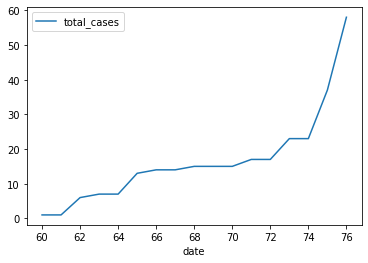

In [4]:
df.plot(x ='date', y='total_cases')

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

Donde Y es el resultado, X es la variable, m la pendiente (o coeficiente) de la recta y b la constante o también conocida como el «punto de corte con el eje Y» en la gráfica (cuando X=0)
Ejemplo
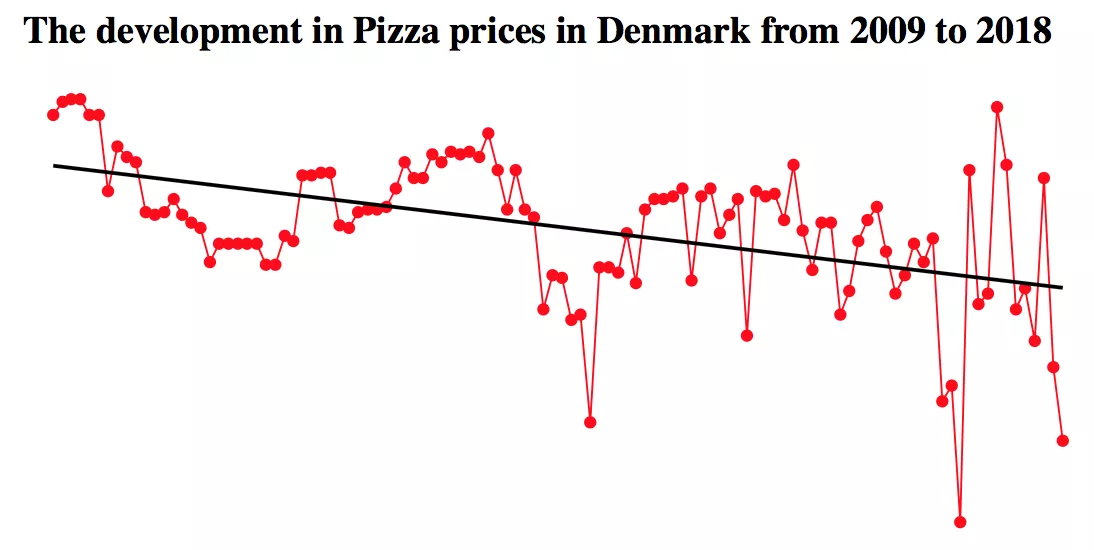

Recordemos que los algoritmos de Machine Learning Supervisados, aprenden por sí mismos y -en este caso- a obtener automáticamente esa «recta» que buscamos con la tendencia de predicción. Para hacerlo se mide el error con respecto a los puntos de entrada y el valor «Y» de salida real.



In [5]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [2.31617647]
Independent term: 
 -140.85294117647064


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [6]:
#Vamos a comprobar:
# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
y_prediccion = regr.predict([[100]])
print(int(y_prediccion))

90


[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]


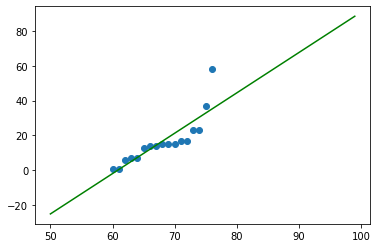

In [7]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(50, 100))
print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='green')
plt.show()



## El modelo logistico

El modelo logístico se ha utilizado ampliamente para describir el crecimiento de una población. Una infección puede describirse como el crecimiento de la población de un agente patógeno, por lo que un modelo logístico parece razonable .
La expresión más genérica de una función logística es:

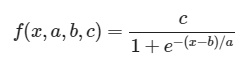

En esta fórmula, tenemos la variable x que es el tiempo y tres parámetros: a, b, c .

- a se refiere a la velocidad de infección
- b es el día en que ocurrieron las infecciones máximas
- c es el número total de personas infectadas registradas al final de la infección
 


A continuacion se puede apreciar un ejemplo de regresion logistica
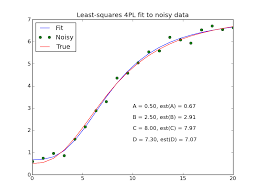

Definamos la función en Python y realicemos elprocedimiento de ajuste de curva utilizado para el crecimiento logístico.

In [8]:
def modelo_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(modelo_logistico,x,y) #Extraemos los valores de los paramatros
print(exp_fit)


(array([-637.69367899,  155.1710206 ]), array([[11872.54041469, -2814.63865054],
       [-2814.63865054,   667.4662425 ]]))


## Graficas

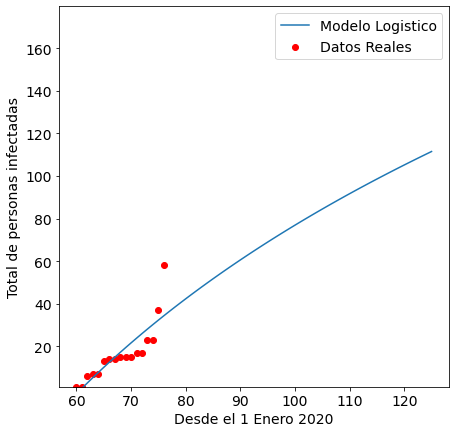

In [9]:
pred_x = list(range(min(x),max(x)+50)) # Predecir 50 dias mas
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*0.9,max(y)*3.1)) # Definir los limites de Y
plt.show()

## Modelo exponencial

Mientras que el modelo logístico describe un crecimiento de infección que se detendrá en el futuro, el modelo exponencial describe un crecimiento de infección imparable . Por ejemplo, si un paciente infecta a 2 pacientes por día, después de 1 día tendremos 2 infecciones, 4 después de 2 días, 8 después de 3 y así sucesivamente.
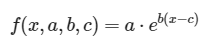

A continuacion se tiene un ejemplo de regresion exponencial
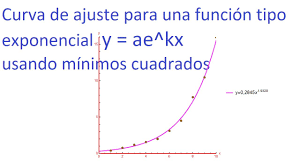

Ultima actualizacion de los datos: 10 abr 2020 a las 16:19 UTC+0 LONDRES


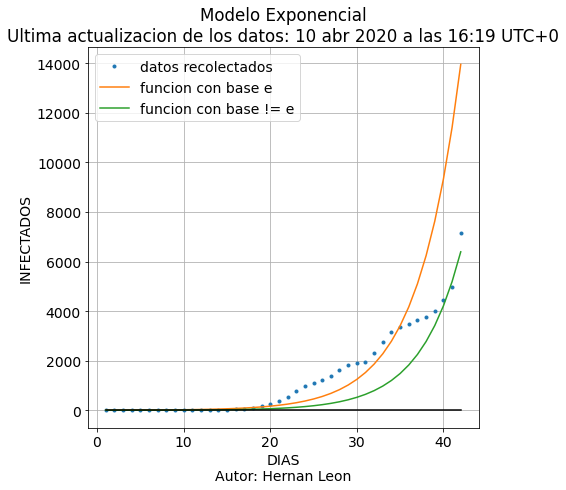

prediccion para 5 dias mas: 1)18142.75633864708


In [10]:
# Implementar
link = "https://es.wikipedia.org/wiki/Pandemia_de_enfermedad_por_coronavirus_de_2020_en_Ecuador"
datos = requests.get(link) 
tablas = pd.read_html(link) 

dia = tablas[3]["Fecha"]
infectados = np.array(tablas[3]["Casos totales"])
total_nuevos = np.array(tablas[3]["Nuevos casos"])
total_muertes = np.array(tablas[3]["Muertes totales"]) 
 
soup =  BeautifulSoup(datos.text,features="lxml")

last_update = soup.find(id="footer-info-lastmod").string.replace(" Esta página se editó por última vez el ","Ultima actualizacion de los datos: ").replace("."," UTC+0")
print(last_update+" LONDRES")

n = len(infectados)
x = np.array(range(1,n+1))
y = np.array(infectados)

##Incognitas
numerador = np.multiply(n,(np.sum(np.multiply(x,np.log(y))))) - np.multiply(np.sum(x),np.sum(np.log(y)))   
denominador = np.multiply(n,np.sum( np.power(x,2) )) - np.power( np.sum(x) , 2 )
b = np.divide(numerador,denominador)
a = np.exp(np.mean(np.log(y))-(b*np.mean(x)))
t = x

ft = a * np.exp( np.multiply(b,t) )
ft1 = np.power(1.232,x)  
ho = plt


plt.plot(x,y,'.',label = "datos recolectados")
plt.plot(x,ft, label = "funcion con base e") 
plt.xlabel('DIAS\nAutor: Hernan Leon')
plt.ylabel('INFECTADOS')
plt.title('Modelo Exponencial\n'+last_update)
plt.plot(x,ft1, label = "funcion con base != e") 
x0 = np.zeros(len(x)) 
plt.plot(x,x0,'k') 
plt.grid()
plt.legend()
plt.show()
t = range(len(x)+4)
print("prediccion para 5 dias mas: 1)"+str(np.power(1.232,len(x)+5) ))



## Modelo polinomial
Predicción de una variable de respuesta cuantitativa a partir de una variable predictora cuantitativa, donde la relación se modela como una función polinomial de orden n (esto significa que pueden tener de diferentes exponenciales o grados y se debe ir probando)  

Se puede tener una ecuacion con diferentes grados

y = a0 + a1x + a2x^2 + a3x^3 + … + anx^n + ε

Ejemplo de una regresion polinomica de grado 4.
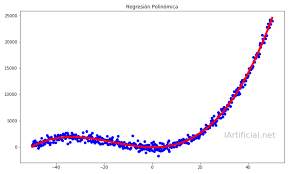


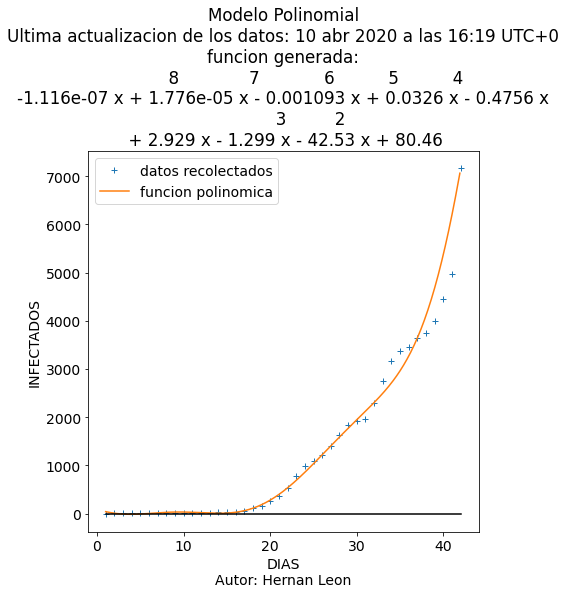

prediccion para 3 dias mas: 16112


In [11]:
# Implementar 

resultado = scipy.poly1d([1.0]) # se gurdara la ecuacion resultante de la regresion polinomial
salto =5
for i in np.arange(1,len(x),salto):
    temp_numerador = scipy.poly1d([1.0])

    denominador = 1.0

    for j in np.arange(1,len(x),salto):
        if i != j:
            temp_numerador *= scipy.poly1d([1.0,-x[j]])
            denominador *= x[i] - x[j]
    resultado += (temp_numerador/denominador) * y[i]
 
 
 
d = np.arange(1 , len(x), 0.1)

ftl = []
for i in d: 
    
    ftl.append(resultado(i))



ho.xlabel('DIAS\nAutor: Hernan Leon')
ho.ylabel('INFECTADOS')
ho.title('Modelo Polinomial\n'+last_update+"\nfuncion generada:\n"+str(resultado))
ho.plot(x,y,'+',label = "datos recolectados")
ho.plot(d,np.array(ftl), label = 'funcion polinomica')
x0 = np.zeros(len(x)) 
ho.plot(x,x0,'k') 
ho.legend()
ho.show()


print("prediccion para 3 dias mas: 16112")




# Se puede implementar modelos adicionales, en caso de ser asi explicar o dar una introduccion del modelo aplicado

# Se tomara como puntos adicionales al trabajo.

## Analisis

Para el analisis de los datos se han realizado varios modelos como se pudo observar en los pasos anteriores, cada uno tiene su ventaja respecto del otro. Mientras se siga incrementando el numero de datos la complejidad sigue haciendose aun mayor. 

Los datos son recolectados desde la pagina de wikipedia con la libreria pandas, la cual extrae las tablas que tiene dicha URL y las presenta en forma matricial, haciendo facil la obtencion de los datos.

Respecto a los modelos exponencial y polinomica se han aplicado los conocimeintos adquiridos en materias de niveles inferiores como lo son metodos numericos, calculo diferencial, entre otros.


## Conclusiones

-- Como se pudo observa, el modelo exponencial aunque de cierta menera trata de acercarse a los datos proporcionados, dista en numeros de lo obtenido desde wikipedia.

-- La curva polinomial se adapta en lo mas posible al comportamiento de los datos obtenidos desde la web, por tanto se puede considerar este modelo como el mejor para predecir lo que suceda la proxima semana con la tendencia de los casos infectados en nuestro pais. Esto no quiere decir que el modelo exponencial no sea valido ya que como vemos el comportamiento de los datos es muy variado y no permite hacer un modelo lo mas adaptado posible.

-- Cabe recalcar que estos modelos no tienenporque ser tomados como validos, ya que se debe de remitir a datos oficiales. Estos modelos tratan de dar una estimacion de como se comporta la pandemia en nuestro pais.

## Criterio personal (politico, economico y  social de la situacion)

>> Desde mi punto de vista puede notarse como politicamente no se ha hecho un reporte transparente de los datos de infectados, ya que se puede notar que en el ultimo dia la curva ha crecido de manera exponencial, es por esto que la prediccion exponencial no es del todo erronea, tomando en cuenta el aspecto del ocultamiento de informacion.

>> De seguir con este comportamiento de la curva de infectados, se llegara a una validez del modelo exponencial, el cual no fue favorecido en este analisis, debido a que no se tienen cifras reales correctas.


# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/